In [171]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import xgboost as xgb
from xgboost import cv

from xgboost import XGBClassifier

In [67]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 960
learning_rate = 0.0001

In [68]:
MADRS_LABLES = ['Normal', 'Mild', 'Moderate']
MADRS_VALUES = [0, 7, 20]
classes = len(MADRS_VALUES)

In [101]:
def create_segments_and_labels_madrs_loo(dataset_dir, segment_length, step, leave_out_id=None):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)
    
    segments = []
    labels = []

    left_out_segments = []
    left_out_correct = None

    if leave_out_id == None:
        leave_out_id = random.randint(0, len(scores['number']))

    for i, person in enumerate(scores['number']):
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        p_label = None

        for j in range(classes):
            if p['madrs2'].values[0] >= MADRS_VALUES[classes - j - 1]:
                p_label = classes - j - 1
                break

        assert p_label != None, f'Could not get target label: {p}'

        # For the participant that we are leaving out
        if i == leave_out_id:
            left_out_correct = p_label

        for j in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[j : j + segment_length]
            
            # For the participant that we are leaving out
            if i == leave_out_id:
                left_out_segments.append([segment])
            else:
                segments.append([segment])
                labels.append(p_label)

    #assert left_out_correct != None and len(left_out_segments) > 0, f'Did not set data for left out participant {leave_out_id}'
    
    labels = np.asarray(labels).astype('float32')
    labels = to_categorical(labels, 3)
    
    segments = np.asarray(segments).reshape(-1, segment_length, 1)
    left_out_segments = np.asarray(left_out_segments).reshape(-1, segment_length, 1)

    num_time_periods, num_sensors = segments.shape[1], segments.shape[2]
    input_shape = num_time_periods * num_sensors

    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    left_out_segments = left_out_segments.reshape(left_out_segments.shape[0], input_shape).astype('float32')
    
    return segments, labels, input_shape

In [102]:
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)

In [71]:
print(segments.shape)
print(labels.shape)

(24998, 960)
(24998, 3)


In [93]:
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)

In [116]:
params = {"objective":"multi:softmax",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'num_class': 3}
model = XGBClassifier(num_boost_rounds = 150, early_stopping_rounds=10, params=params)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[15:28:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_boost_rounds, params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:28:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters

----------- 24h segment lenghts --------

In [122]:
segment_length = 1440
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)
print(X.shape)
print(Y.shape)
params = {"objective":"multi:softmax",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'num_class': 3}
model = XGBClassifier(num_boost_rounds = 150, early_stopping_rounds=10, params=params)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

(24276, 1440)
(24276,)
[16:11:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_boost_rounds, params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:11:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/lear

----------- 48h segment lenghts --------

In [125]:
segment_length = 2880
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)
print(X.shape)
print(Y.shape)
params = {"objective":"multi:softmax",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'num_class': 3}
model = XGBClassifier(num_boost_rounds = 150, early_stopping_rounds=10, params=params)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

(23267, 2880)
(23267,)
[16:52:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_boost_rounds, params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:52:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:54:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/lear

----------- 72h segment lenghts --------

In [126]:
segment_length = 4320
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)
print(X.shape)
print(Y.shape)
params = {"objective":"multi:softmax",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10, 'num_class': 3}
model = XGBClassifier(num_boost_rounds = 150, early_stopping_rounds=10, params=params)
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

(22261, 4320)
(22261,)
[17:12:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_boost_rounds, params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:12:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:14:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/lear

----------- 96h segment lenghts --------

In [127]:
segment_length = 5760
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)
model = XGBClassifier()
kfold = KFold(n_splits=4, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[18:00:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

In [ ]:
%matplotlib inline
values = ['16h', '24h', '48h', '72h','96h'] 

plt.figure(figsize=(10, 5))
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.plot(values,acc, marker = 'o')
plt.xticks(values)
plt.xlabel("Segments")
plt.ylabel("Accuracy")
plt.title("LSTM accuracy per segment after 3-fold cross-validation on test set")

--------- XGBoost without CV -------- 16h

In [234]:
segment_length = 960

In [235]:
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)

In [236]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.33, random_state=7)
X = segments
Y = labels
Y = np.argmax(Y, axis = 1)


In [237]:
print(X_train.shape)
print(y_train)

(16632, 960)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [238]:
y_train = np.argmax(y_train, axis = 1)
print(y_train.shape)

(16632,)


In [239]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

[21:37:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [240]:
y_test = np.argmax(y_test, axis = 1)

In [241]:
multilabel_confusion_matrix(y_pred,y_test)

array([[[1209,  332],
        [1604, 5047]],

       [[6372,  993],
        [ 377,  450]],

       [[6451, 1027],
        [ 371,  343]]])

In [249]:
cm = confusion_matrix(y_pred,y_test)
print(cm)


[[4983  587  783]
 [ 122  413  193]
 [ 108  150  331]]


In [265]:
import numpy as np

target_names = ["no depression","mild depression","moderate depression"]


def plot_confusion_matrix(cm,
                          target_names,
                          title=title,
                          cmap=None,
                          normalize=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()



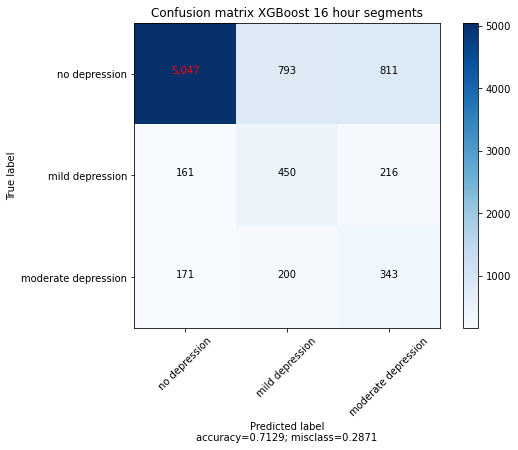

None


In [246]:
print(plot_confusion_matrix(cm,target_names))

In [192]:
print(accuracy_score(y_pred,y_test))

0.715030303030303


--------- XGBoost 24h no CV -------

In [254]:
segment_length = 1440
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.33, random_state=7)
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred,y_test)
target_names = ["no depression","mild depression","moderate depression"]




[21:55:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


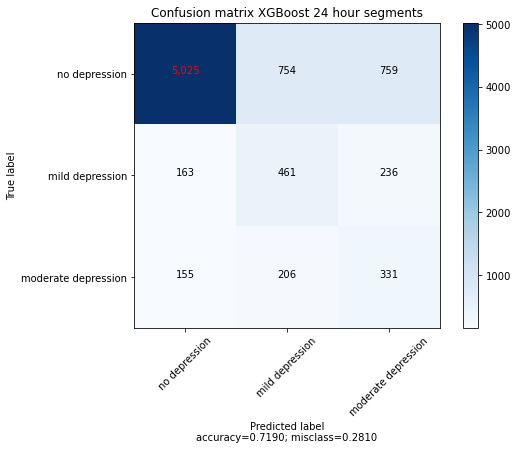

None


In [257]:
title='Confusion matrix XGBoost 24 hour segments'
print(plot_confusion_matrix(cm,target_names))

----- 48h segments

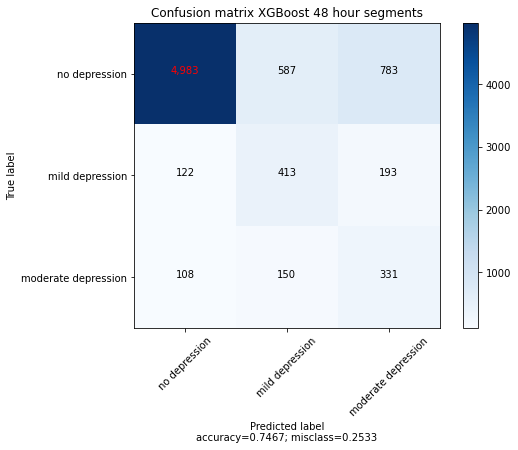

None


In [252]:
title='Confusion matrix XGBoost 48 hour segments'
print(plot_confusion_matrix(cm,target_names))

---- 72h segments

In [258]:
segment_length = 4320
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.33, random_state=7)
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred,y_test)

[21:59:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


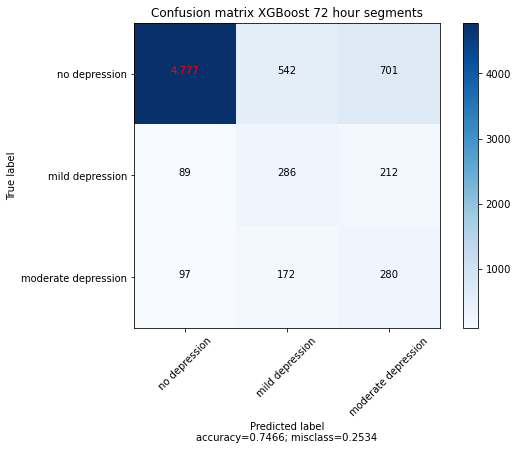

None


In [262]:
title='Confusion matrix XGBoost 72 hour segments'
print(plot_confusion_matrix(cm,target_names))

In [263]:
segment_length = 5760
segments, labels, input_shape = create_segments_and_labels_madrs_loo(data_dir,segment_length,step)
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.33, random_state=7)
y_train = np.argmax(y_train, axis = 1)
y_test = np.argmax(y_test, axis = 1)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred,y_test)

[22:08:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


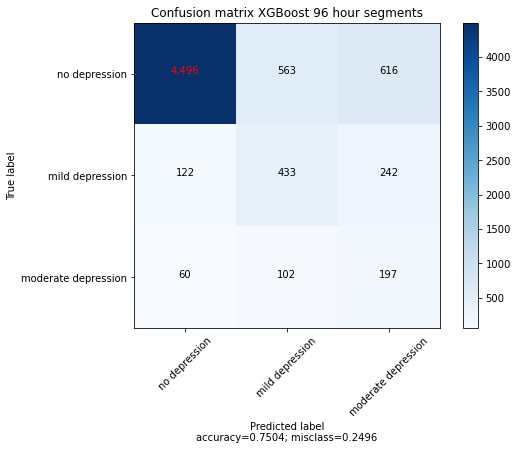

None


In [266]:
title='Confusion matrix XGBoost 96 hour segments'
print(plot_confusion_matrix(cm,target_names))